# SIMPLE OBJECT DETECTION FROM SCRATCH USING NEURAL NETWORKS
Based on https://github.com/jrieke/shape-detection/blob/master/single-rectangle.ipynb
and https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491

### Imports

In [1]:
#Basics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#For the models
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


### Parameters

In [2]:
#number of images in the dataset.
num_imgs = 50000

#dimension of squared images
img_size = 8

#min and max dimensions of the objects
min_object_size = 1
max_object_size = 4

#number of objects per image
num_objects = 1

#defines the number of images for the training phase
training_set_factor = 0.8

### Metric Function

In [3]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection 
    over the area of union'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

### Prepare the dataset data

In [4]:
#initialize bbox matrix
bboxes = np.zeros((num_imgs, num_objects, 4)) #why there is a '4'?
#initialize the images with zero values for each 'pixel'
#the images are going to have a single layer
#Question: What should we do to have rgb images?
imgs = np.zeros((num_imgs, img_size, img_size)) #why there is two 'img_size'?

#randomly create objects in the initialized images.
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w) #how does this work?
        y = np.random.randint(0, img_size - h) #how does this work?
        #fill the pixels which belongs to the object
        imgs[i_img, x:x+w, y:y+h] = 1.  # what does mean the dot in the end of the value?
        bboxes[i_img, i_object] = [x, y, w, h]
        
#See, we can show values by just calling the variables. Ps: an once per cell.        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

### Check a sample of the data

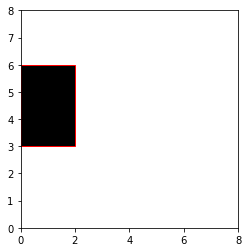

In [5]:
#randomly select a image ID
i = np.random.randint(0,num_imgs)

plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
# Example of documentation: Interpolation: https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html

for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='None'))

### Normalize and prepare data in the input format for the network

In [6]:
# Reshape and normalize the image data to mean 0 and std 1. 
# X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
# X.shape, np.mean(X), np.std(X)

X = imgs.reshape(num_imgs, -1)
X.shape, np.mean(X), np.std(X)

((50000, 64), 0.062554374999999995, 0.24215971004351525)

In [7]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 0.28153624999999999, 0.17537726102872486)

### Split training and test.

In [8]:
i = int(training_set_factor * num_imgs)

#network input format
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]

#raw format
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

### Creating the model

In [9]:
model = Sequential([
        Dense(200, input_dim=X.shape[-1]),
        Activation('relu'), 
        Dropout(0.2), 
        Dense(y.shape[-1]) #what is the output?
    ])
#or
'''
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
'''

model.compile('adadelta', 'mse')

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               13000     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 804       
Total params: 13,804
Trainable params: 13,804
Non-trainable params: 0
_________________________________________________________________


### Training

In [11]:
model.fit(train_X, train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
#or model.load_weights("model.h5")

/home/gustavo/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 5s - loss: 0.0068 - val_loss: 8.8767e-04


### Save the model

In [12]:
#weights
model.save_weights("obj_detect_model.h5")

#model
model_json = model.to_json()
with open("obj_detect_model.json", "w") as json_file:
    json_file.write(model_json)

### Testing

In [13]:
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

### Showing a random sample from the tests

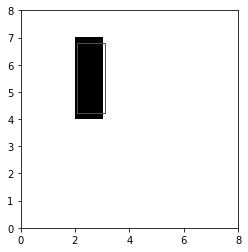

In [18]:
#randomly select a image ID
i = np.random.randint(0,len(test_X))

plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
# Example of documentation: Interpolation: https://matplotlib.org/gallery/images_contours_and_fields/interpolation_methods.html

for bbox in pred_bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

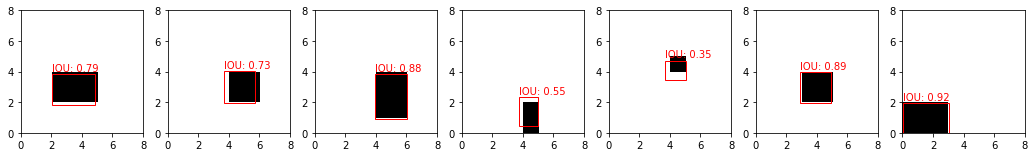

In [15]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(18, 3))
for i_subplot in range(1, 8):
    plt.subplot(1, 7, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [16]:
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.66298581333028939

# QUESTIONS
* What are the limitations of this model?
    * The images have a single channel;
    * There are always one object per image;
    * There nothing else besides the object in the image;
* How can we improve our model to achieve higher IoU score?